In [1]:
!pip install lime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tools for accessing and reading data (you do not need to use all of them)
import os
import pathlib
import PIL
import cv2
import skimage
from IPython.display import Image, display
from matplotlib.image import imread
import matplotlib.cm as cm

# Tensorflow basics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image


#Lime package for ML explainability
from lime import lime_image

# for reproducibility (does not guarantee fully reproducible results )
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=16f4fb0335a2c84e526803769053f3d220b13e78f3eb5ef9ecd47af74c6cac37
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import zipfile

with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512')

In [3]:
dataset_url = "/content/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512/"
data_dir = pathlib.Path(dataset_url)
data_dir.head()

PosixPath('/content/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

0


In [5]:
import pathlib
import PIL

# ... (other imports) ...

dataset_url = "/content/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512/casting_512x512/casting_512x512"
data_dir = pathlib.Path(dataset_url)

# Use the correct file extension in the glob pattern
def_front = list(data_dir.glob('def_front/*.jpeg'))

# Check if the list is empty before accessing elements
if def_front:
    PIL.Image.open(def_front[0])
else:
    print("No images found in def_front directory.")

In [6]:
import pathlib
import PIL

# Assuming your images are JPEGs, change the glob pattern
ok_front = list(data_dir.glob('ok_front/*.jpeg'))

# Check if the list is empty before accessing elements
if ok_front:
    PIL.Image.open(ok_front[0])
else:
    print("No images found in ok_front directory.")

In [7]:
sample1= imread(ok_front[0])
sample1.shape

(512, 512, 3)

In [8]:
batch_size = 64
epochs=200
img_height = 299
img_width = 299
img_size = (img_height, img_width)

In [9]:
train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    class_names =  ['ok_front', 'def_front'],
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 1040 files for training.


In [10]:
val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    class_names =  ['ok_front', 'def_front'],
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 260 files for validation.


In [11]:
class_names = train_set.class_names
print(class_names)

['ok_front', 'def_front']


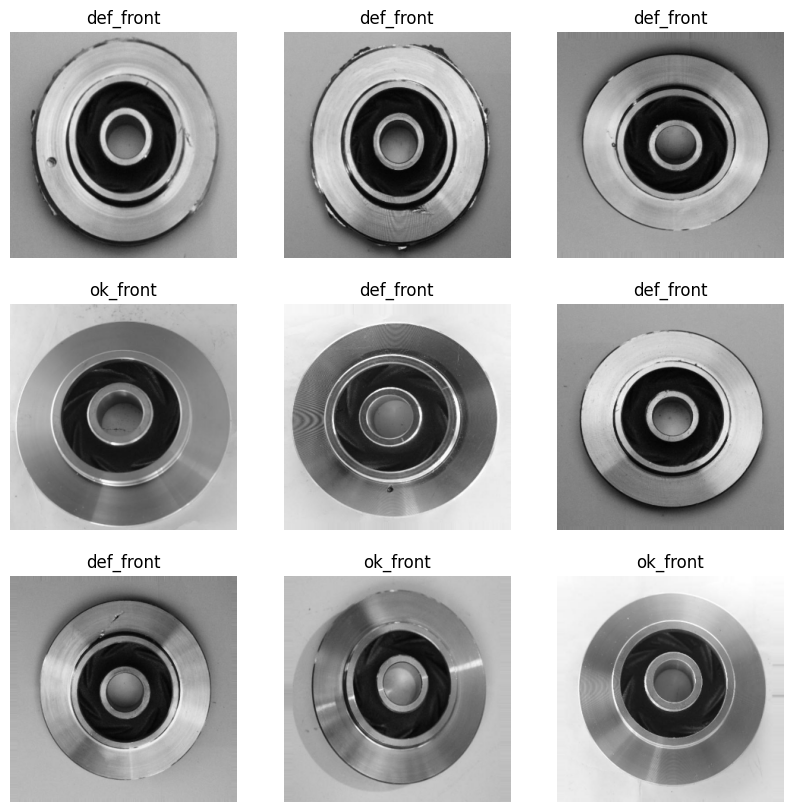

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for images, labels in train_set:
  print(images.shape)
  print(labels.shape)
  break

(64, 299, 299, 3)
(64,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3), seed = seed ),
    layers.RandomZoom(0.1, seed = seed ),
    layers.RandomContrast(0.3, seed = seed  )
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
custom_model = Sequential([

  layers.Rescaling(1./255),
  data_augmentation,

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [17]:
custom_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') == 1.0 and logs.get('val_accuracy') == 1.0:
            print("\nReached 100% accuracy so cancelling training!")
            self.model.stop_training = True

terminate_callback = myCallback()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    verbose=1,
    min_delta=0.01,
    patience=5,
    min_lr=0.00001
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history1 = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[reduce_lr, terminate_callback, checkpoint_callback]
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5777 - loss: 0.7006
Epoch 1: val_accuracy improved from -inf to 0.61923, saving model to model_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.5780 - loss: 0.6999 - val_accuracy: 0.6192 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6303 - loss: 0.6632
Epoch 2: val_accuracy improved from 0.61923 to 0.73077, saving model to model_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - accuracy: 0.6312 - loss: 0.6626 - val_accuracy: 0.7308 - val_loss: 0.5726 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7184 - loss: 0.5863
Epoch 3: val_accuracy improved from 0.73077 to 0.73846, saving model to model_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.7185 - loss: 0.5859 - val_accuracy: 0.7385 - val_loss: 0.5476 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - 

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') == 1.0 and logs.get('val_accuracy') == 1.0 :
            print("\nReached 100% accuracy so cancelling training!")
            self.model.stop_training = True

terminate_callback =  myCallback()

In [20]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1,min_delta=0.01,
                              patience=5, min_lr=0.000001)


In [21]:
history1 = custom_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=20,
                            callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.9308 - loss: 0.1788 - val_accuracy: 0.9538 - val_loss: 0.1505 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.9027 - loss: 0.2376 - val_accuracy: 0.9385 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.9374 - loss: 0.1561 - val_accuracy: 0.9500 - val_loss: 0.1570 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.9367 - loss: 0.1674 - val_accuracy: 0.9538 - val_loss: 0.1079 - learning_rate: 0.0010
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.9525 - loss: 0.1377 - val_accuracy: 0.9654 - val_loss: 0.1081 - learning_rate: 0.0010
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.9495 - loss: 0.1394 - val_accuracy: 0.9769 - val_loss: 0.0873 - learning_rate: 0.0010
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.9489 - loss: 0.1383 - 

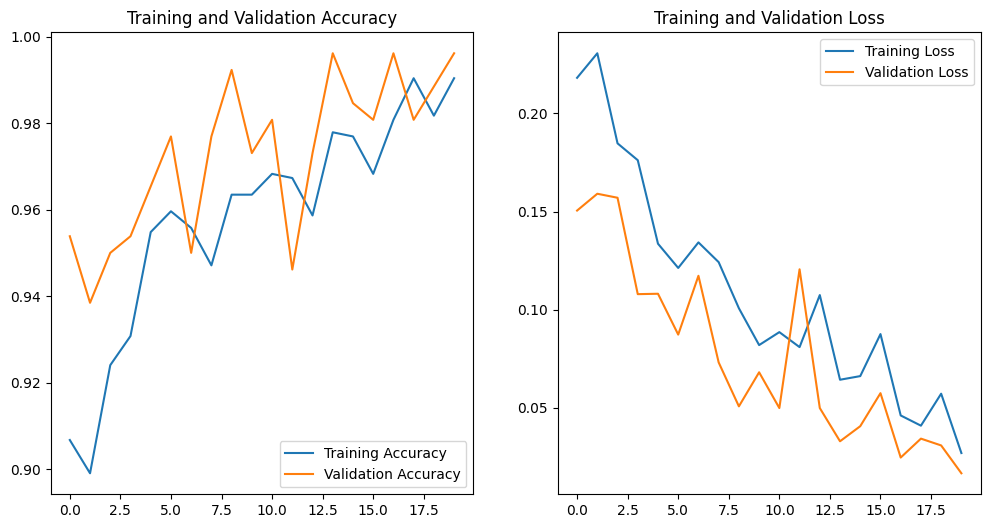

In [22]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))

x = data_augmentation(inputs)  # Apply random data augmentation

x = keras.layers.Rescaling(scale=1 / 255.0)(x)

x = base_model(x, training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
pretrained_model = keras.Model(inputs, outputs)

In [25]:
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [26]:
history2 = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks= [reduce_lr, terminate_callback]
)
# Save the entire model
pretrained_model.save('my_model.h5')

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 880ms/step - accuracy: 0.5869 - loss: 11.9230 - val_accuracy: 0.8000 - val_loss: 1.7326 - learning_rate: 0.0010
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 623ms/step - accuracy: 0.8473 - loss: 1.4730 - val_accuracy: 0.9769 - val_loss: 0.1113 - learning_rate: 0.0010
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 646ms/step - accuracy: 0.9538 - loss: 0.2264 - val_accuracy: 0.9115 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step - accuracy: 0.9470 - loss: 0.1993 - val_accuracy: 0.9577 - val_loss: 0.1616 - learning_rate: 0.0010
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 657ms/step - accuracy: 0.9744 - loss: 0.1154 - val_accuracy: 0.9923 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 654ms/step - accuracy: 0.9750 - loss: 0.0796 - val_accuracy: 0.9923 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step - accuracy: 0.9847 - loss: 0

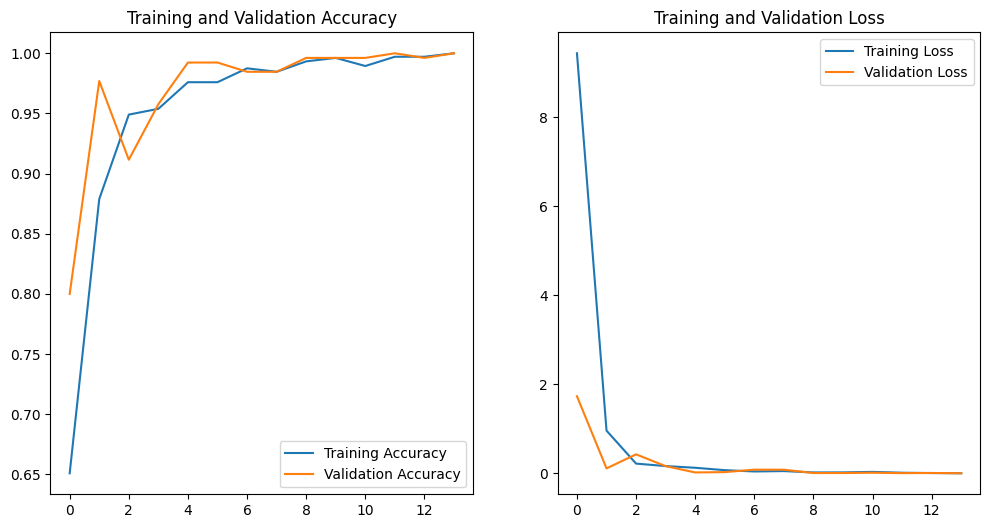

In [27]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
pretrained_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      26,214,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,505,453 (379.58 MB)

 Trainable params: 26,214,657 (100.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 52,429,316 (200.00 MB)

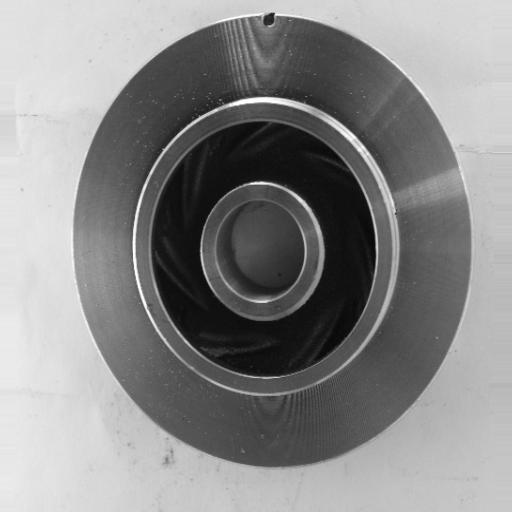

In [29]:
img_path = '/content/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512/casting_512x512/casting_512x512/def_front/cast_def_0_238.jpeg'
display(Image(img_path))

In [30]:
def get_img_array(img_path, size):
    # `Sİze of image 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [31]:
images = get_img_array(img_path, img_size)
preds = pretrained_model.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [32]:
if prediction == 1:
    print("ok")
else:
    print("not_ok")

print(pct)

not_ok
0.99999976


In [37]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load your model (replace 'your_model.h5' with your actual model file)
pretrained_model = load_model('my_model.h5')

def get_img_array(img_path, size):
    # Load the image with the specified target size
    img = image.load_img(img_path, target_size=size)

    # Convert the image to an array
    array = image.img_to_array(img)

    # Expand dimensions to match the model's input shape (1, height, width, channels)
    array = np.expand_dims(array, axis=0)

    # Normalize the image if your model was trained on normalized data
    array /= 255.0  # Adjust if necessary based on your training setup

    return array

# Set your image size here
img_size = (299, 299)  # Adjust to match your model input size
img_path = '/content/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512/casting_512x512/casting_512x512/def_front/cast_def_0_0.jpeg'  # Change to your image path

# Get the image array
images = get_img_array(img_path, img_size)

# Make predictions
preds = pretrained_model.predict(images)

# Get the predicted class index
prediction = np.argmax(preds, axis=1)[0]  # Get the index of the class with highest probability
pct = np.max(preds)  # Get the highest confidence level

# Define your class mapping if you have specific labels
class_mapping = {0: 'not_ok', 1: 'ok'}  # Update this to match your classes

# Print results
if prediction in class_mapping:
    print(f'Prediction: {class_mapping[prediction]}')
else:
    print('Unknown class. Please check your class mapping.')

print(f'Confidence: {pct:.4f}')  # Print the confidence of the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: not_ok
Confidence: 0.9999


In [39]:
model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
last_conv_layer_name = "block14_sepconv2_act"

In [40]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


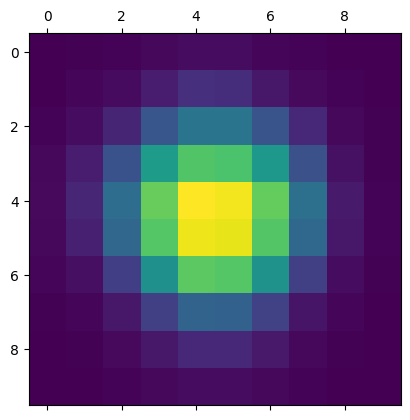

In [41]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
grad_cam_model = model_builder(weights="imagenet")

# Remove last layer's softmax
grad_cam_model.layers[-1].activation = None


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, grad_cam_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-42-34e0b9574523>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


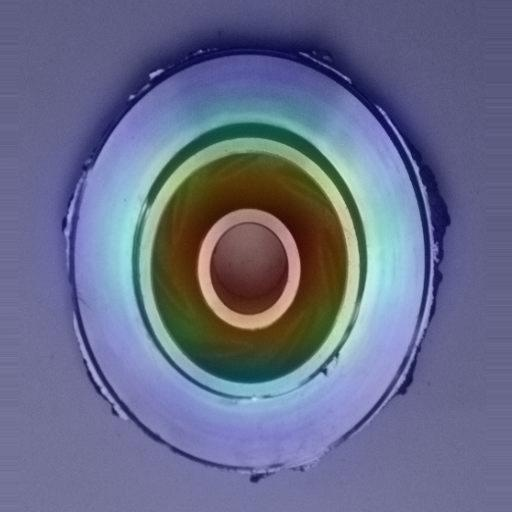

In [42]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [43]:
explainer = lime_image.LimeImageExplainer()

In [44]:
explanation = explainer.explain_instance(images[0].astype('double'), custom_model.predict,
                                        top_labels=2, hide_color=0, num_samples=300)

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

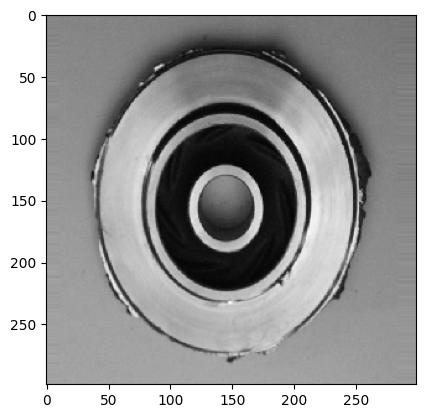

In [45]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=False)

plt.imshow(mark_boundaries(temp_1, mask_1))


In [ ]:
tensor -version


In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.1
